# Initial setup

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt

from bokeh.io import output_file, output_notebook, show, reset_output
from bokeh.plotting import figure, ColumnDataSource, save
from bokeh.models import GeoJSONDataSource, LogColorMapper, LinearColorMapper, HoverTool, Slider, ColorBar, FixedTicker
from bokeh.palettes import OrRd as palette

### Set repo base folder

In [2]:
Base_folder = "/Users/Daniel/Desktop/MSc Data Science/Dissertaton Project/Repo/Vis-EHR"

### Folder settings, import shapefile and data

In [3]:
# Shapefile data
shapefile_folder = os.path.join(Base_folder, "Shapefile")
shapefilename = "MSOA_Wal_Eng_Scot.geojson"
shapefile_path = os.path.join(shapefile_folder, shapefilename)

# Covid cases data
covid_data_folder = os.path.join(Base_folder,"Data/Covid Cases data")
date_selected = "07-07-2021"
eng_filename = "England_MSOA_Cases_2021-07-07" + ".csv"
wal_filename = "Wales_MSOA_Cases_2021-07-07" + ".csv"
scot_filename = "Scotland_IZ_Cases_2021-07-07" + ".csv"

covid_eng = os.path.join(covid_data_folder, date_selected, eng_filename)
covid_wal = os.path.join(covid_data_folder, date_selected, wal_filename)
covid_scot = os.path.join(covid_data_folder, date_selected, scot_filename)

# Area names data
areaName_folder = os.path.join(Base_folder,"Data/Area codes and names")
eng_wal_namefile = "England-Wales-MSOA-Names.csv"
scot_namefile = "Scotland-IZ-Names.csv"

area_eng_wal = os.path.join(areaName_folder, eng_wal_namefile)
area_scot = os.path.join(areaName_folder, scot_namefile)

# Population data
pop_folder = os.path.join(Base_folder, "Data/Population estimates")
eng_wal_popfile = "England_Wales_Population_by_age.csv"
scot_popfile = "Scotland_Population_by_age.csv"

pop_eng_wal = os.path.join(pop_folder, eng_wal_popfile)
pop_scot = os.path.join(pop_folder, scot_popfile)

# Output file settings
output_file(os.path.join(Base_folder,"Visualisation Dev", "UK_covid_cases.html"), title="UK Covid Cases", mode='inline')

# Read in Shapefile, covid data files, area name files
shapefile = gpd.read_file(shapefile_path)

eng_covid_data = pd.read_csv(covid_eng, header=0)
wal_covid_data = pd.read_csv(covid_wal, header=0)
scot_covid_data = pd.read_csv(covid_scot, header=0)

eng_wal_areaNames = pd.read_csv(area_eng_wal, header=0)
scot_areaNames = pd.read_csv(area_scot, header=0)

eng_wal_pop = pd.read_csv(pop_eng_wal, header=0)
scot_pop = pd.read_csv(pop_scot, header=0)

## File testing

In [42]:
scot_pop.head()

,IntZone,IntZoneQF,Sex,SexQF,AllAges,Age0,Age1,Age2,Age3,Age4,...,Age81,Age82,Age83,Age84,Age85,Age86,Age87,Age88,Age89,Age90plus
0,S92000003,d,All,d,5463300,50772,52734,54266,56539,57404,...,31191,28436,26237,23904,21126,18701,17001,14569,12032,43658
1,S02001236,NaN,All,d,4733,46,38,37,46,41,...,33,28,21,11,19,25,12,12,12,59
2,S02001237,NaN,All,d,4831,46,34,42,55,50,...,30,33,25,24,10,14,21,15,19,107
3,S02001238,NaN,All,d,6840,44,42,44,81,69,...,57,37,32,40,28,19,26,30,27,92
4,S02001239,NaN,All,d,5581,43,63,54,57,65,...,29,28,25,27,17,21,20,12,18,29


## Shapefile plot (and boundaries)

<AxesSubplot:>

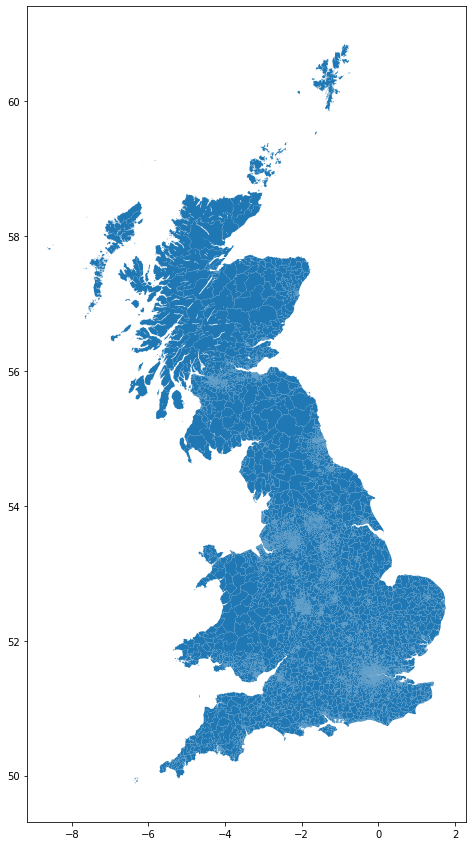

In [6]:
shapefile.plot(figsize=(10, 15))
# plt.savefig(os.path.join(Base_folder, "Visualisation Dev", "MSOA_Shapefile_plot.jpg"))

<AxesSubplot:>

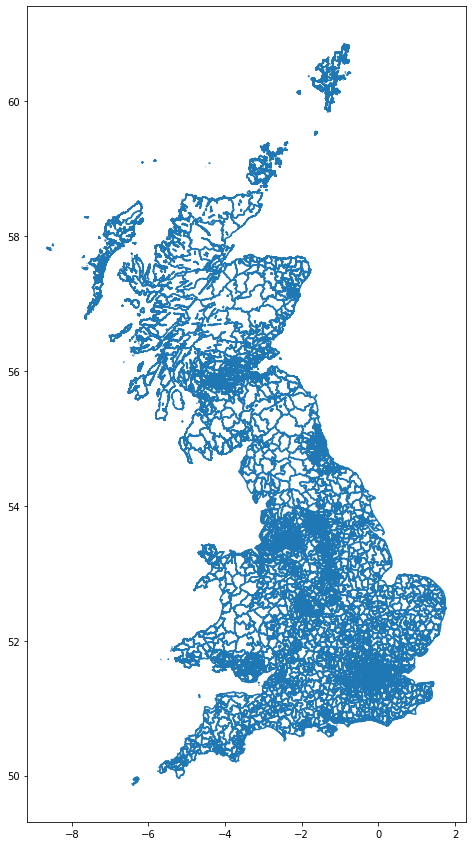

In [7]:
shapefile.boundary.plot(figsize=(10, 15))
# plt.savefig(os.path.join(Base_folder, "Visualisation Dev", "MSOA_Shapefile_boundary.jpg"))

## Building the dataset from sources

In [49]:
eng_wal_pop.head()

,code,MSOA Name,LA Code (2019 boundaries),LA name (2019 boundaries),LA Code (2020 boundaries),LA name (2020 boundaries),pop_count,0-4,5-9,10-14,...,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90+
0,E02002483,Hartlepool 001,E06000001,Hartlepool,E06000001,Hartlepool,"10,261",621,689,671,...,755,713,665,546,479,500,325,251,185,48
1,E02002484,Hartlepool 002,E06000001,Hartlepool,E06000001,Hartlepool,"10,449",608,740,687,...,591,703,762,657,552,533,278,241,155,107
2,E02002485,Hartlepool 003,E06000001,Hartlepool,E06000001,Hartlepool,"8,185",536,637,544,...,510,577,546,453,375,433,264,207,112,29
3,E02002487,Hartlepool 005,E06000001,Hartlepool,E06000001,Hartlepool,"5,277",315,271,254,...,332,372,353,272,235,172,123,96,54,17
4,E02002488,Hartlepool 006,E06000001,Hartlepool,E06000001,Hartlepool,"5,848",237,311,370,...,421,496,463,432,386,322,229,178,100,60


In [4]:
# Rename column headings for consistency
eng_covid_data.rename(columns={"areaCode":"code", "newCasesBySpecimenDateRollingSum":"Cases"}, inplace=True) 
wal_covid_data.rename(columns={"MSOA code":"code"}, inplace=True)
scot_covid_data.rename(columns={"IntZone":"code", "Positive7Day":"Cases"}, inplace=True)

eng_wal_areaNames.rename(columns={"msoa11cd":"code", "msoa11hclnm": "areaName"}, inplace=True)
scot_areaNames.rename(columns={"InstanceCode":"code", "InstanceName": "areaName"}, inplace=True)

eng_wal_pop.rename(columns={"MSOA Code":"code", "All Ages": "pop_count"}, inplace=True)
scot_pop.rename(columns={"IntZone":"code", "AllAges": "pop_count"}, inplace=True)

# Drop first row of scotland pop (total)
scot_pop = scot_pop.iloc[1:, :]

In [5]:
# Concat Eng, Wal, Scot covid data
df_list = [eng_covid_data[["code", "Cases"]], wal_covid_data[["code", "Cases"]], scot_covid_data[["code", "Cases"]]]
full_covid_data = pd.concat(df_list)

# Concat Eng, Wal, Scot area names
names_list = [eng_wal_areaNames[["code", "areaName"]], scot_areaNames[["code", "areaName"]]]
full_areaNames = pd.concat(names_list)

# Concat Eng, Wal, Scot pop data
pop_list = [eng_wal_pop[["code", "pop_count"]], scot_pop[["code", "pop_count"]]]
full_pop_count = pd.concat(pop_list)

# Merge covid data to shapefile
covid_df = pd.merge(shapefile[["code", "geometry"]],
              full_covid_data[["code", "Cases"]],
              on="code",
              how="left")

# Merge area names to dataframe
area_df = pd.merge(covid_df,
              full_areaNames[["code", "areaName"]],
              on="code",
              how="left")

# Merge pop counts to dataframe
df = pd.merge(area_df,
              full_pop_count[["code", "pop_count"]],
              on="code",
              how="left")

# replace all "0-2" values with zero (Only applies to wales data)
df.loc[df.Cases == "0-2", 'Cases'] = 0
df["Cases"] = pd.to_numeric(df["Cases"])
df["pop_count"] = df['pop_count'].replace({',':''}, regex=True)
df["pop_count"] = pd.to_numeric(df["pop_count"])

# Calculate case rate from 'cases' and "pop_count" columns
df["Case_rate"] = round(df["Cases"] / df["pop_count"], 6)

# Save file here
df.to_file(os.path.join(Base_folder,"Data", "Visualisation_data.geojson"), driver = 'GeoJSON')

In [54]:
(df["Cases"] < 3).sum()

32

In [52]:
(df["code"].isna() == True).sum()

0

In [53]:
len(df.index)

8480

## Building Custom plots

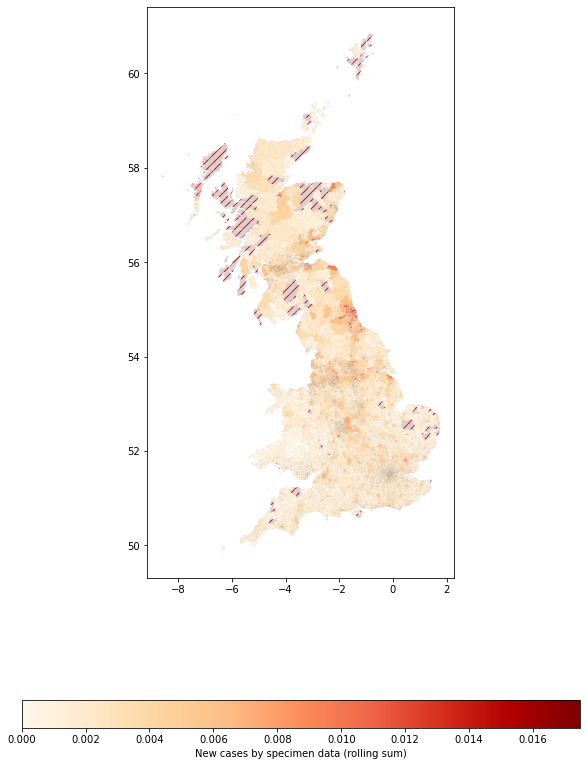

In [69]:
fig, axis = plt.subplots(1,1, figsize=(10,15))
df.plot(column="Case_rate",
            cmap="OrRd",
            figsize=(10, 15),
            ax = axis,
            edgecolor="black",
            linewidth=0.015,
            legend = True,
            legend_kwds={"label": "New cases by specimen data (rolling sum)",
                            "orientation": "horizontal"},
            missing_kwds= {'color': "lightgrey", 'hatch':'///', 'edgecolor':'red'})

plt.savefig(os.path.join(Base_folder, "Visualisation Dev", "MSOA_covid_cases_7day.jpg"))

In [7]:
# export to json and read into Bokeh
df_Bokeh = GeoJSONDataSource(geojson=df.to_json())

# Plot 
tools_list = ['pan', 'box_zoom', 'wheel_zoom', 'tap', 'save', 'reset']
myplot = figure(title="UK cumulative covid cases (Week prior to 2021-07-07)",
               toolbar_location = 'right',
               plot_width= 600,
               plot_height= 750,
               tools = tools_list)

myplot.xgrid.grid_line_color = None
myplot.ygrid.grid_line_color = None
myplot.axis.visible = False

minval = min(df["Case_rate"])
maxval = max(df["Case_rate"])

OrRd_palette = list(reversed(palette[6]))
mypalette = LinearColorMapper(palette=OrRd_palette,
                              low=minval,
                              high=maxval,
                              nan_color="lightgray")

mypatch = myplot.patches('xs', 'ys', fill_alpha=1, 
          fill_color={'field': 'Case_rate', 'transform': mypalette}, 
          line_color='black', line_width=0.1, source=df_Bokeh)

myplot.add_tools(HoverTool(renderers=[mypatch],
                          tooltips = [("MSOA name", "@areaName"),
                                      ("Population", "@pop_count"),
                                      ("Cases", "@Cases"),
                                      ("Case rate", "@Case_rate")]))

num_ticks = 6
tick_diff = (maxval-minval)/num_ticks
tick_vals = [minval, round(minval+tick_diff, 6), round(minval+(2*tick_diff), 6), round(minval+(3*tick_diff), 6), round(maxval-(2*tick_diff), 6), round(maxval-(tick_diff), 6), maxval]
cb_ticks = FixedTicker(ticks=tick_vals)

color_bar = ColorBar(color_mapper=mypalette,
                     label_standoff=10,
                     ticker=cb_ticks,
                     bar_line_color="black",
                     bar_line_width=1,
                     major_label_text_color="black",
                     major_tick_line_color="black",
                     major_tick_line_width=2,
                     major_tick_in=25)

myplot.add_layout(color_bar, 'below')

save(myplot)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/Daniel/Desktop/MSc Data Science/Dissertaton Project/Repo/Vis-EHR/Visualisation Dev/UK_covid_cases.html'